In [1]:
import ee
import geemap
import logging
import multiprocessing
import os
import torch
import pandas as pd
from skimage.measure.entropy import shannon_entropy
import numpy as np
import re
import rasterio
import matplotlib.pyplot as plt
import json
from utils.functions import getResult, getRequests, get_files_info
GEE_PROJECT_ID = "fusion-371234"
ee.Authenticate()
ee.Initialize(project=GEE_PROJECT_ID)

In [27]:
Map = geemap.Map()
Map = geemap.Map(center=[39.3583, 116.75], zoom=14)
Map.add_basemap("HYBRID")

Map

Map(center=[39.3583, 116.75], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(chil…

In [28]:
# Convert to GeoJSON format
geojson_dict = Map.user_roi.getInfo()

# Save to file
with open("china.json", "w") as f:
    json.dump(geojson_dict, f)

print("✅ Region saved as china.json")

✅ Region saved as china.json


In [35]:
S2_SR_COLLECTION_ID = "COPERNICUS/S2_HARMONIZED"
selected_bands = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12']
CLOUD_FILTER = 50
PROCESSES = multiprocessing.cpu_count() - 1
dimensions = "256x256"
buffer = (int(dimensions.split('x')[0]) / 2) * 10 
crs = "EPSG:4326"
num_samples = 4
DATE = ["2019-08-01", "2019-08-31"]
with open("china.json", "r") as f:
    region_data = json.load(f)

# Convert to Earth Engine Geometry
region = ee.Geometry(region_data)

params = {
    "count": num_samples,  # How many image sample points to export
    "buffer": buffer,  # The buffer distance (m) around each point
    "scale": 10,  # The scale to do stratified sampling
    "bands": None, # The bands to export
    "seed": 1,  # A randomization seed to use for subsampling.
    "dimensions": dimensions,  # The dimension of each image chip
    "format": "GEO_TIFF",  # The output image format, can be png, jpg, ZIPPED_GEO_TIFF, GEO_TIFF, NPY
    "prefix": "sample_",  # The filename prefix
    "processes": min(25, PROCESSES),  # How many processes to used for parallel processing
    "out_dir": "china_2019_08_07_2019_08_27",  # The output directory. Default to the current working directly
    "crs": crs,  # The CRS to use for the output image
}

s2_sr_col = ee.ImageCollection(S2_SR_COLLECTION_ID).filterBounds(region).filterDate(DATE[0], DATE[1]).filter(ee.Filter.lte('CLOUDY_PIXEL_PERCENTAGE', CLOUD_FILTER))


params['bands'] = [{
    'id': band, 
    'scale': (
        10 if band in ['B2', 'B3', 'B4', 'B8'] else 
        20 if band in ['B5', 'B6', 'B7', 'B8A', 'B11', 'B12'] else 
        60
    ), 
    'crs': params['crs']} for band in selected_bands]


In [43]:
images = []
samples = []
col_size = s2_sr_col.size().getInfo()
print(f"Number of images: {col_size}")
for i in range(col_size):
    sr_img = s2_sr_col.toList(s2_sr_col.size()).getInfo()[i]
    id = sr_img['properties']['PRODUCT_ID']
    sr_img = s2_sr_col.filter(ee.Filter.eq("PRODUCT_ID", id)).first()
    sr_img = sr_img.select(selected_bands)
    images.append(sr_img)
    samples.append(id)

os.makedirs(params['out_dir'], exist_ok=True)
for i in range(len(images)):
    image = images[i]
    id = samples[i]
    logging.basicConfig()
    items = getRequests(params, image, region)
    pool = multiprocessing.Pool(params["processes"])
    pool.starmap(getResult, [(index, item, image, params, id) for index, item in enumerate(items)])
    pool.close()      

Number of images: 8


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/china_2019_08_07_2019_08_27/20190801_S2B_MSIL1C_20190801T030549_N0208_R075_T50SMJ_20190801T064211_sample_2.tif
Download Completed: /home/fekenzofugi/Documents/rsad-time-series/china_2019_08_07_2019_08_27/20190801_S2B_MSIL1C_20190801T030549_N0208_R075_T50SMJ_20190801T064211_sample_3.tif
Download Completed: /home/fekenzofugi/Documents/rsad-time-series/china_2019_08_07_2019_08_27/20190801_S2B_MSIL1C_20190801T030549_N0208_R075_T50SMJ_20190801T064211_sample_1.tif
Download Completed: /home/fekenzofugi/Documents/rsad-time-series/china_2019_08_07_2019_08_27/20190801_S2B_MSIL1C_20190801T030549_N0208_R075_T50SMJ_20190801T064211_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/china_2019_08_07_2019_08_27/20190806_S2A_MSIL1C_20190806T030551_N0208_R075_T50SMJ_20190806T060210_sample_0.tif
Download Completed: /home/fekenzofugi/Documents/rsad-time-series/china_2019_08_07_2019_08_27/20190806_S2A_MSIL1C_20190806T030551_N0208_R075_T50SMJ_20190806T060210_sample_3.tif
Download Completed: /home/fekenzofugi/Documents/rsad-time-series/china_2019_08_07_2019_08_27/20190806_S2A_MSIL1C_20190806T030551_N0208_R075_T50SMJ_20190806T060210_sample_2.tif
Download Completed: /home/fekenzofugi/Documents/rsad-time-series/china_2019_08_07_2019_08_27/20190806_S2A_MSIL1C_20190806T030551_N0208_R075_T50SMJ_20190806T060210_sample_1.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/china_2019_08_07_2019_08_27/20190808_S2B_MSIL1C_20190808T025549_N0208_R032_T50SMJ_20190808T071557_sample_1.tif
Download Completed: /home/fekenzofugi/Documents/rsad-time-series/china_2019_08_07_2019_08_27/20190808_S2B_MSIL1C_20190808T025549_N0208_R032_T50SMJ_20190808T071557_sample_3.tif
Download Completed: /home/fekenzofugi/Documents/rsad-time-series/china_2019_08_07_2019_08_27/20190808_S2B_MSIL1C_20190808T025549_N0208_R032_T50SMJ_20190808T071557_sample_2.tif
Download Completed: /home/fekenzofugi/Documents/rsad-time-series/china_2019_08_07_2019_08_27/20190808_S2B_MSIL1C_20190808T025549_N0208_R032_T50SMJ_20190808T071557_sample_0.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/china_2019_08_07_2019_08_27/20190816_S2A_MSIL1C_20190816T030551_N0208_R075_T50SMJ_20190816T064328_sample_1.tif
Download Completed: /home/fekenzofugi/Documents/rsad-time-series/china_2019_08_07_2019_08_27/20190816_S2A_MSIL1C_20190816T030551_N0208_R075_T50SMJ_20190816T064328_sample_2.tif
Download Completed: /home/fekenzofugi/Documents/rsad-time-series/china_2019_08_07_2019_08_27/20190816_S2A_MSIL1C_20190816T030551_N0208_R075_T50SMJ_20190816T064328_sample_0.tif
Download Completed: /home/fekenzofugi/Documents/rsad-time-series/china_2019_08_07_2019_08_27/20190816_S2A_MSIL1C_20190816T030551_N0208_R075_T50SMJ_20190816T064328_sample_3.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/china_2019_08_07_2019_08_27/20190818_S2B_MSIL1C_20190818T025549_N0208_R032_T50SMJ_20190818T054043_sample_3.tif
Download Completed: /home/fekenzofugi/Documents/rsad-time-series/china_2019_08_07_2019_08_27/20190818_S2B_MSIL1C_20190818T025549_N0208_R032_T50SMJ_20190818T054043_sample_1.tif
Download Completed: /home/fekenzofugi/Documents/rsad-time-series/china_2019_08_07_2019_08_27/20190818_S2B_MSIL1C_20190818T025549_N0208_R032_T50SMJ_20190818T054043_sample_0.tif
Download Completed: /home/fekenzofugi/Documents/rsad-time-series/china_2019_08_07_2019_08_27/20190818_S2B_MSIL1C_20190818T025549_N0208_R032_T50SMJ_20190818T054043_sample_2.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/china_2019_08_07_2019_08_27/20190821_S2B_MSIL1C_20190821T030549_N0208_R075_T50SMJ_20190821T064227_sample_1.tif
Download Completed: /home/fekenzofugi/Documents/rsad-time-series/china_2019_08_07_2019_08_27/20190821_S2B_MSIL1C_20190821T030549_N0208_R075_T50SMJ_20190821T064227_sample_3.tif
Download Completed: /home/fekenzofugi/Documents/rsad-time-series/china_2019_08_07_2019_08_27/20190821_S2B_MSIL1C_20190821T030549_N0208_R075_T50SMJ_20190821T064227_sample_0.tif
Download Completed: /home/fekenzofugi/Documents/rsad-time-series/china_2019_08_07_2019_08_27/20190821_S2B_MSIL1C_20190821T030549_N0208_R075_T50SMJ_20190821T064227_sample_2.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/china_2019_08_07_2019_08_27/20190823_S2A_MSIL1C_20190823T025551_N0208_R032_T50SMJ_20190823T061030_sample_2.tif
Download Completed: /home/fekenzofugi/Documents/rsad-time-series/china_2019_08_07_2019_08_27/20190823_S2A_MSIL1C_20190823T025551_N0208_R032_T50SMJ_20190823T061030_sample_0.tif
Download Completed: /home/fekenzofugi/Documents/rsad-time-series/china_2019_08_07_2019_08_27/20190823_S2A_MSIL1C_20190823T025551_N0208_R032_T50SMJ_20190823T061030_sample_1.tif
Download Completed: /home/fekenzofugi/Documents/rsad-time-series/china_2019_08_07_2019_08_27/20190823_S2A_MSIL1C_20190823T025551_N0208_R032_T50SMJ_20190823T061030_sample_3.tif


Download Completed: /home/fekenzofugi/Documents/rsad-time-series/china_2019_08_07_2019_08_27/20190828_S2B_MSIL1C_20190828T025549_N0208_R032_T50SMJ_20190828T072229_sample_3.tif
Download Completed: /home/fekenzofugi/Documents/rsad-time-series/china_2019_08_07_2019_08_27/20190828_S2B_MSIL1C_20190828T025549_N0208_R032_T50SMJ_20190828T072229_sample_1.tif
Download Completed: /home/fekenzofugi/Documents/rsad-time-series/china_2019_08_07_2019_08_27/20190828_S2B_MSIL1C_20190828T025549_N0208_R032_T50SMJ_20190828T072229_sample_2.tif
Download Completed: /home/fekenzofugi/Documents/rsad-time-series/china_2019_08_07_2019_08_27/20190828_S2B_MSIL1C_20190828T025549_N0208_R032_T50SMJ_20190828T072229_sample_0.tif


Total number of files: 2
Found 2 matching images.
RGB loaded with downsample factor: 1x


/tmp/ipykernel_14273/2768205051.py:78: UserWarning: Treat the new Tool classes introduced in v1.5 as experimental for now; the API and rcParam may change in future versions.
  plt.rcParams['toolbar'] = 'toolmanager'


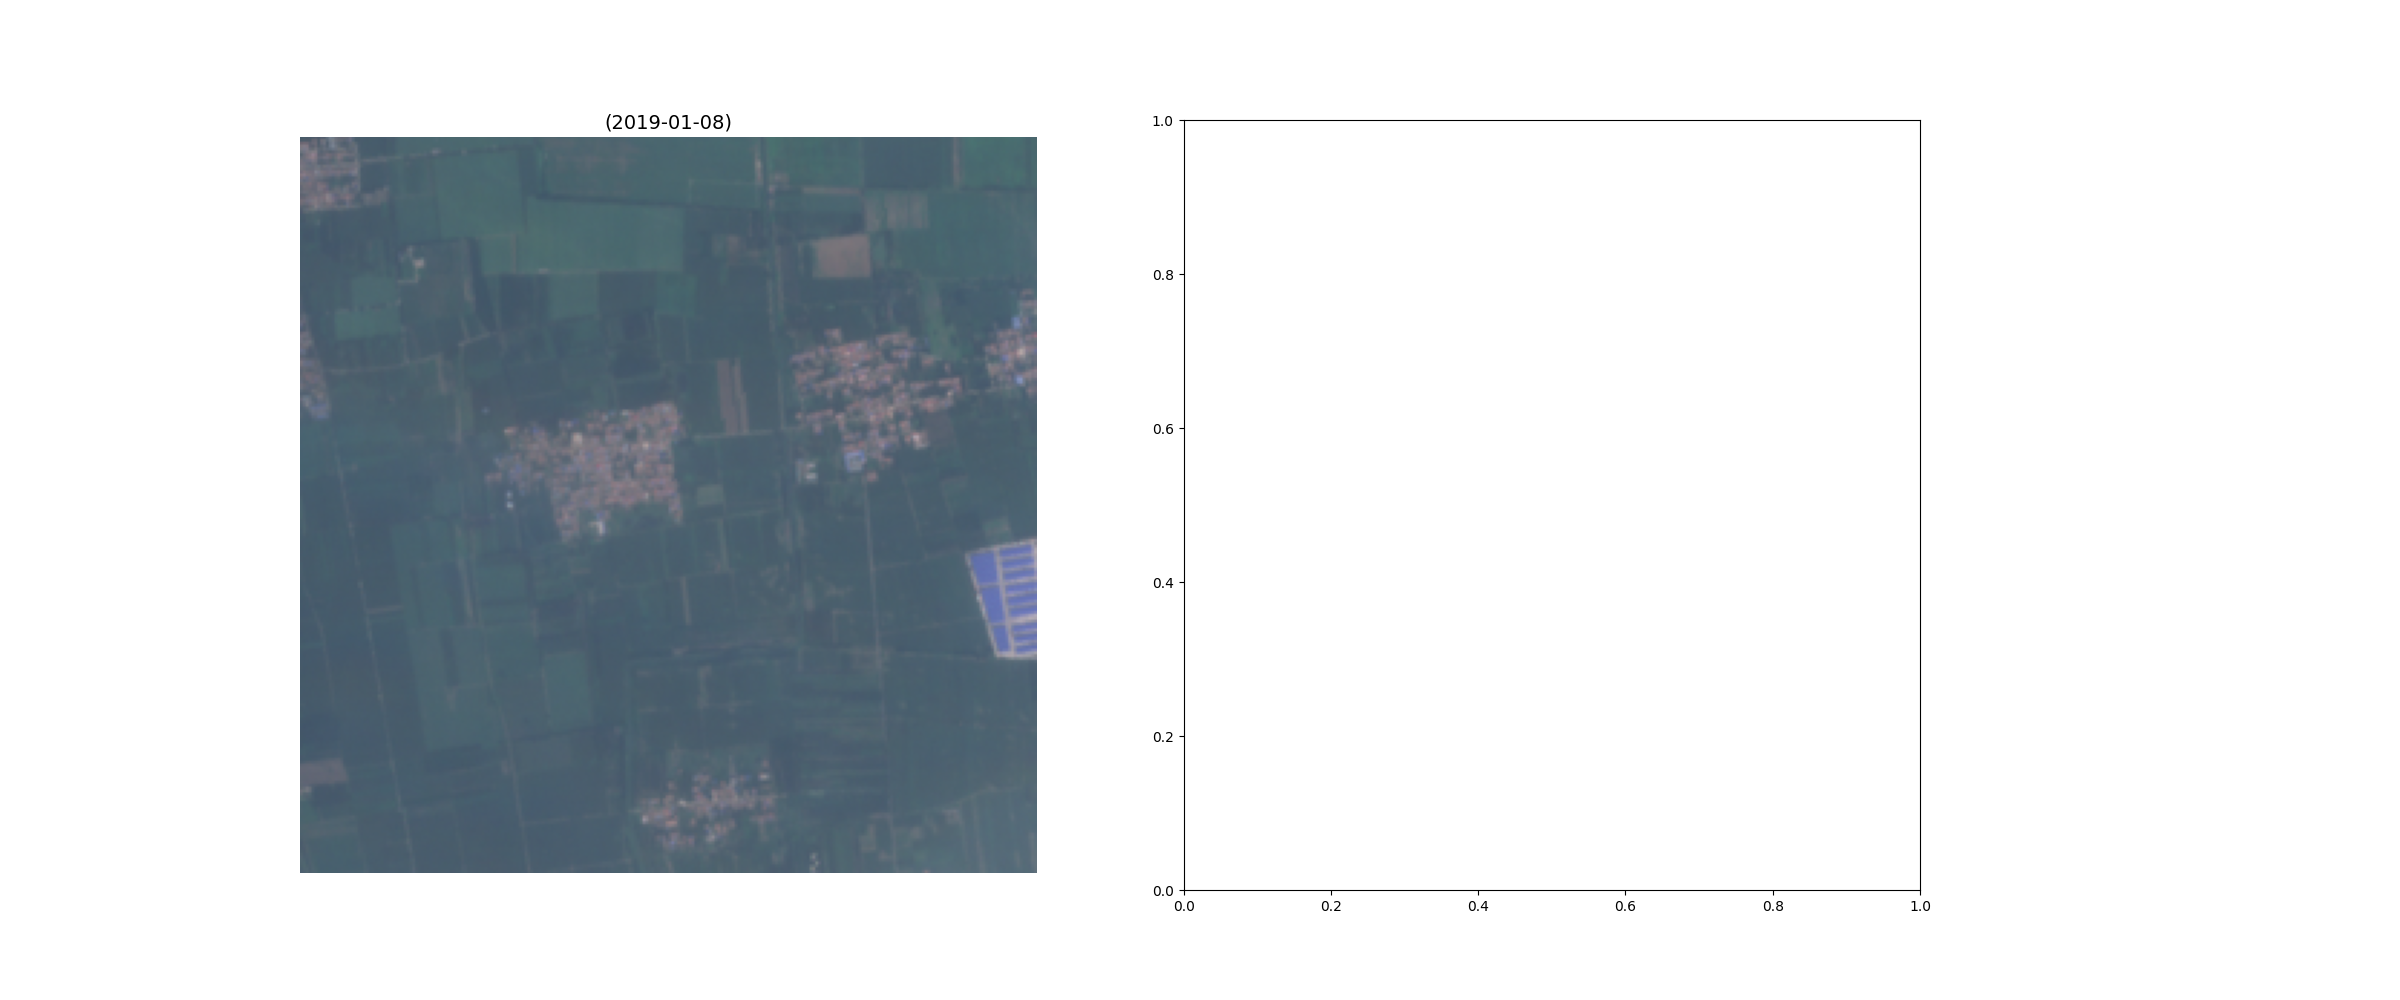

2367

In [42]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
import rasterio
import os
import re
from datetime import datetime
import gc

# ==============================
# PARÂMETROS
# ==============================
scale = 3000
sample_point = "2"

# ==============================
# LISTA E FILTRA ARQUIVOS
# ==============================
n_files, name_files = get_files_info(params["out_dir"])
name_files = sorted(name_files)
matching_files = [f for f in name_files if re.match(rf".*_{sample_point}.*\.tif$", f)]
n_images = len(matching_files)
print(f"Found {n_images} matching images.")

# ==============================
# EXTRAI DATAS E CAMINHOS (SEM CARREGAR IMAGENS)
# ==============================
file_paths = []
dates = []

for f in matching_files:
    file_paths.append(os.path.join(params["out_dir"], f))
    
    match = re.search(r"_(\d{8})T", f)
    if match:
        date_str = match.group(1)
        date = datetime.strptime(date_str, "%Y%m%d")
        dates.append(date)
    else:
        dates.append(None)

# ==============================
# CARREGA APENAS A IMAGEM DE EXIBIÇÃO
# ==============================
n_image = 0

def load_rgb_image(file_path, bands=[4, 3, 2], max_size=1500):
    """Carrega apenas as bandas RGB necessárias com downsampling"""
    with rasterio.open(file_path) as src:
        # Calcula fator de downsampling
        height, width = src.height, src.width
        downsample = max(1, int(np.ceil(max(height, width) / max_size)))
        
        # Lê com downsampling nativo do rasterio (muito mais rápido)
        rgb = np.stack([
            src.read(b, out_shape=(
                height // downsample,
                width // downsample
            )) for b in bands
        ], axis=0) / scale
        
    return np.clip(rgb.transpose(1, 2, 0), 0, 1), downsample

img_rgb, downsample_factor = load_rgb_image(file_paths[n_image])
print(f"RGB loaded with downsample factor: {downsample_factor}x")

# Cache para NDVI de pixels clicados
ndvi_cache = {}

# ==============================
# CRIA FIGURA INTERATIVA
# ==============================
fig, (ax_img, ax_spec) = plt.subplots(
    1, 2, figsize=(24, 10),
    gridspec_kw={'width_ratios': [1, 1]}
)
fig.subplots_adjust(right=0.8)
plt.rcParams['toolbar'] = 'toolmanager'

# ==============================
# MOSTRA IMAGEM RGB
# ==============================
ax_img.imshow(img_rgb)
ax_img.set_title(f"({dates[n_image].strftime('%Y-%d-%m')})", fontsize=14)
ax_img.axis("off")

# ==============================
# FUNÇÃO OTIMIZADA DE PLOT NDVI
# ==============================
def calculate_ndvi_pixel(x, y):
    """Calcula NDVI para um pixel específico em todas as datas"""
    cache_key = (x, y)
    
    # Verifica cache
    if cache_key in ndvi_cache:
        return ndvi_cache[cache_key]
    
    ndvi_values = []
    
    for file_path in file_paths:
        # Abre arquivo e lê apenas o pixel necessário
        with rasterio.open(file_path) as src:
            # Lê janela de 1x1 pixel nas bandas NIR (8) e RED (4)
            window = rasterio.windows.Window(x, y, 1, 1)
            red = src.read(4, window=window)[0, 0] / scale
            nir = src.read(8, window=window)[0, 0] / scale
        
        ndvi = (nir - red) / (nir + red + 1e-6)
        ndvi_values.append(ndvi)
    
    # Armazena no cache
    ndvi_cache[cache_key] = ndvi_values
    
    # Limita tamanho do cache (mantém últimos 50 pixels)
    if len(ndvi_cache) > 50:
        oldest_key = next(iter(ndvi_cache))
        del ndvi_cache[oldest_key]
    
    return ndvi_values

def plot_ndvi_time_series(x, y):
    """Plota série temporal de NDVI para um pixel"""
    ax_spec.clear()
    ax_spec.set_title(f"NDVI ao longo do tempo — pixel ({x}, {y})", fontsize=14)
    ax_spec.set_xlabel("Data")
    ax_spec.set_ylabel("NDVI")
    ax_spec.grid(True, linestyle="--", alpha=0.7)
    
    # Calcula NDVI
    ndvi_values = calculate_ndvi_pixel(x, y)
    
    # Ordena por data
    valid_pairs = sorted(
        [(d, n) for d, n in zip(dates, ndvi_values) if d is not None],
        key=lambda x: x[0]
    )
    
    if valid_pairs:
        sorted_dates, sorted_ndvi = zip(*valid_pairs)
        ax_spec.plot(sorted_dates, sorted_ndvi, "o-", color="green", 
                    label="NDVI", linewidth=2, markersize=6)
        ax_spec.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    fig.canvas.draw_idle()

# ==============================
# EVENTO DE CLIQUE
# ==============================
def onclick(event):
    if event.inaxes != ax_img:
        return
    
    # Ajusta coordenadas pelo fator de downsample
    x, y = int(event.xdata * downsample_factor), int(event.ydata * downsample_factor)
    
    # Valida coordenadas
    if x < 0 or y < 0:
        return
    
    print(f"Pixel clicked: ({x}, {y})")
    plot_ndvi_time_series(x, y)

fig.canvas.mpl_connect("button_press_event", onclick)

plt.show()

# Limpeza final
del img_rgb
gc.collect()

/tmp/ipykernel_6601/627166904.py:12: UserWarning: Treat the new Tool classes introduced in v1.5 as experimental for now; the API and rcParam may change in future versions.
  plt.rcParams['toolbar'] = 'toolmanager'


NameError: name 'img_rgb' is not defined

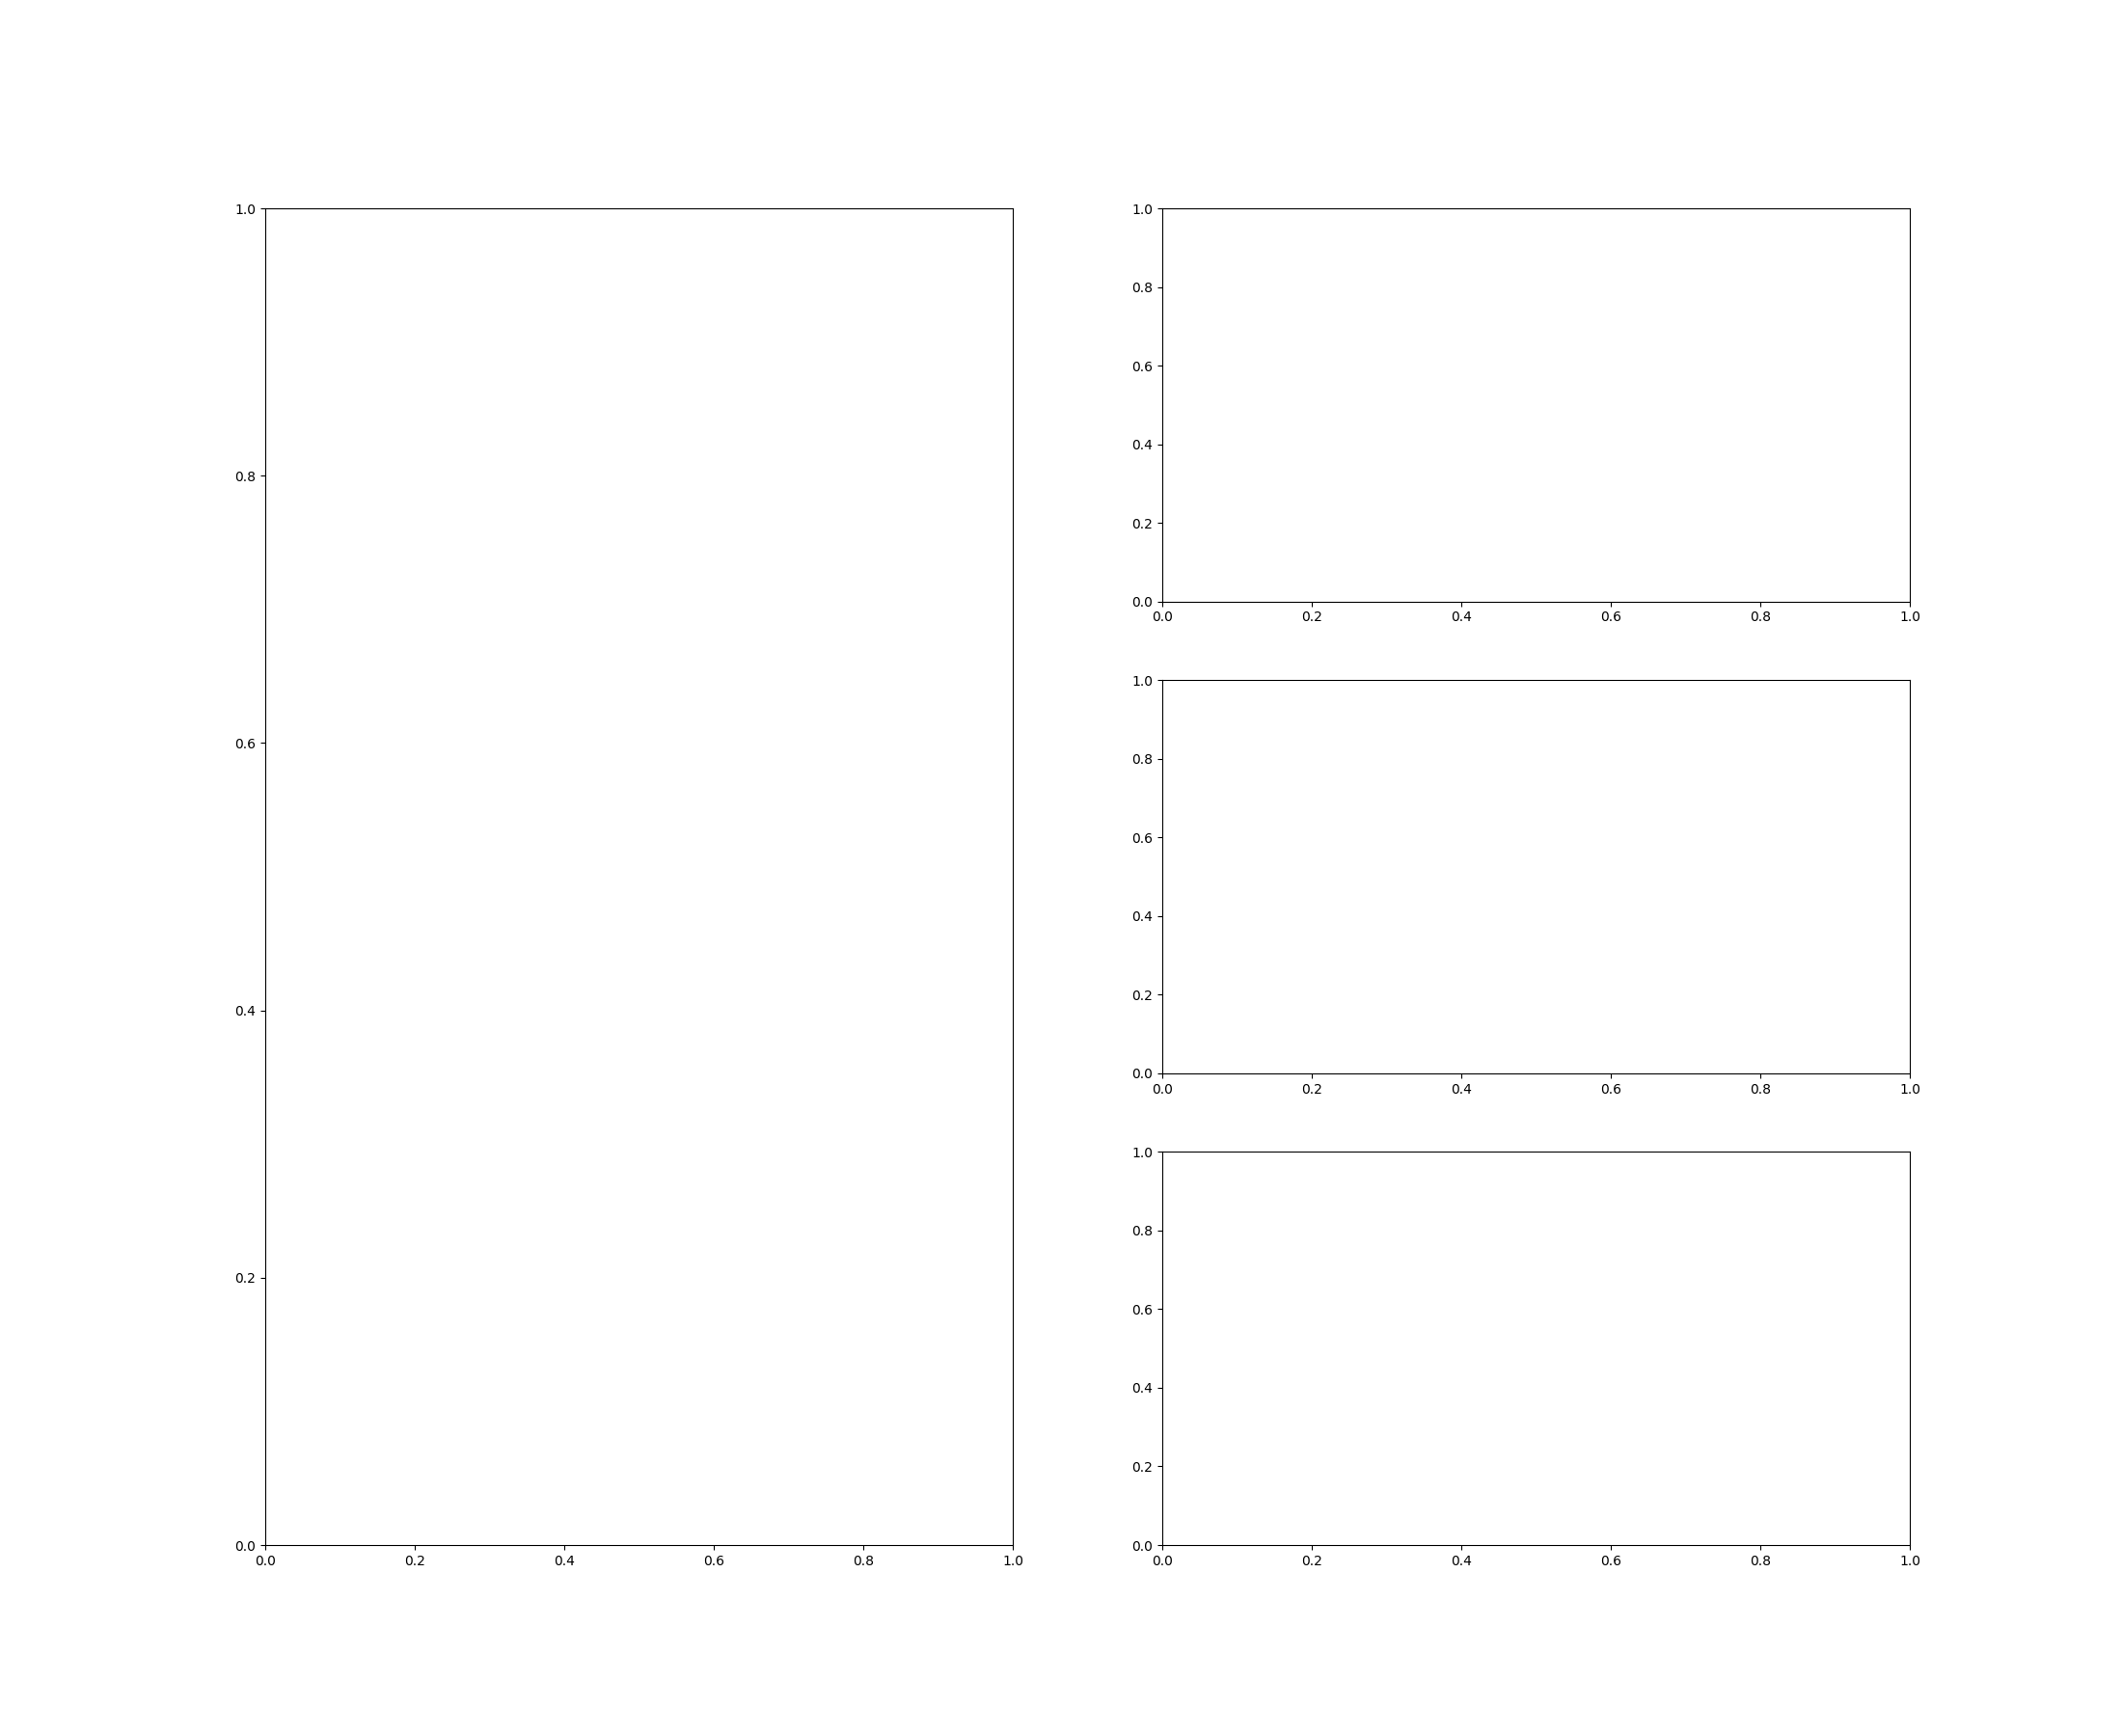

In [6]:
# ==============================
# FIGURA COM 1 COLUNA RGB + 3 LINHAS DE ÍNDICES
# ==============================
fig = plt.figure(figsize=(22, 18))
gs = fig.add_gridspec(3, 2, width_ratios=[1, 1], height_ratios=[1, 1, 1])

ax_img  = fig.add_subplot(gs[:, 0])   # imagem ocupa 3 linhas da coluna esquerda
ax_ndvi = fig.add_subplot(gs[0, 1])   # NDVI no topo
ax_pmli = fig.add_subplot(gs[1, 1])   # PMLI no meio
ax_bsi  = fig.add_subplot(gs[2, 1])   # BSI embaixo

plt.rcParams['toolbar'] = 'toolmanager'

# ==============================
# MOSTRA IMAGEM RGB
# ==============================
ax_img.imshow(img_rgb)
ax_img.set_title(f"({dates[n_image].strftime('%Y-%m-%d')})", fontsize=14)
ax_img.axis("off")


# ==============================
# FUNÇÃO: NDVI + PMLI + BSI
# ==============================
def plot_indices_time_series(x, y):

    ax_ndvi.clear()
    ax_pmli.clear()
    ax_bsi.clear()

    # Listas de valores
    ndvi_values = []
    pmli_values = []
    bsi_values = []

    for img in images:
        blue  = img[1, y, x]     # B2
        red   = img[3, y, x]     # B4
        nir   = img[7, y, x]     # B8
        swir1 = img[10, y, x]    # B11

        ndvi = (nir - red) / (nir + red + 1e-6)
        pmli = (swir1 - red) / (swir1 + red + 1e-6)
        bsi  = ((swir1 + red) - (nir + blue)) / ((swir1 + red) + (nir + blue) + 1e-6)

        ndvi_values.append(ndvi)
        pmli_values.append(pmli)
        bsi_values.append(bsi)

    # Ordenar por data
    valid_pairs = sorted(
        [(d, a, b, c) for d, a, b, c in zip(dates, ndvi_values, pmli_values, bsi_values) if d is not None],
        key=lambda x: x[0]
    )

    sorted_dates = [p[0] for p in valid_pairs]
    sorted_ndvi  = [p[1] for p in valid_pairs]
    sorted_pmli  = [p[2] for p in valid_pairs]
    sorted_bsi   = [p[3] for p in valid_pairs]


    # ==================================
    # NDVI
    # ==================================
    ax_ndvi.plot(sorted_dates, sorted_ndvi, "o-", color="green")
    ax_ndvi.set_title("NDVI", fontsize=14)
    ax_ndvi.set_ylabel("NDVI")
    ax_ndvi.grid(True, linestyle="--")

    # ==================================
    # PMLI
    # ==================================
    ax_pmli.plot(sorted_dates, sorted_pmli, "o-", color="orange")
    ax_pmli.set_title("PMLI", fontsize=14)
    ax_pmli.set_ylabel("PMLI")
    ax_pmli.grid(True, linestyle="--")

    # ==================================
    # BSI
    # ==================================
    ax_bsi.plot(sorted_dates, sorted_bsi, "o-", color="red")
    ax_bsi.set_title("BSI", fontsize=14)
    ax_bsi.set_xlabel("Data")
    ax_bsi.set_ylabel("BSI")
    ax_bsi.grid(True, linestyle="--")

    fig.canvas.draw_idle()


# ==============================
# EVENTO DE CLIQUE
# ==============================
def onclick(event):
    if event.inaxes != ax_img:
        return

    x, y = int(event.xdata), int(event.ydata)
    print(f"Pixel clicked: ({x}, {y})")

    plot_indices_time_series(x, y)

fig.canvas.mpl_connect("button_press_event", onclick)
plt.show()


Total number of files: 92
Found 23 matching images.


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as 

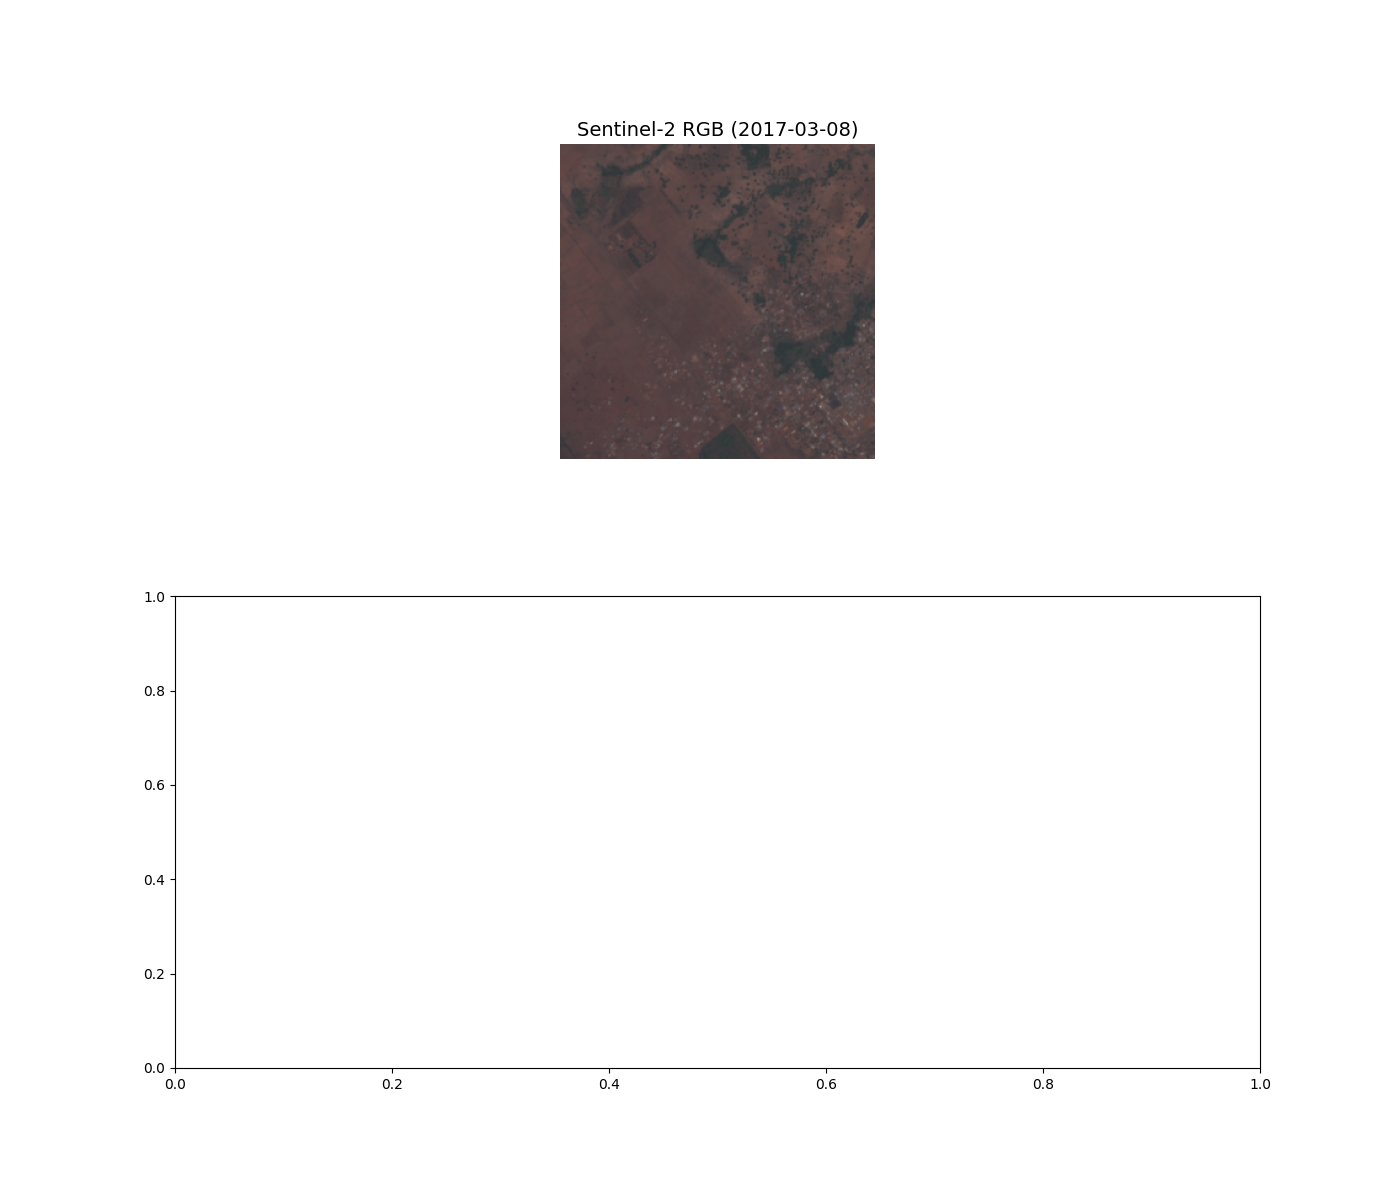

In [7]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
import rasterio
import os
import re
from datetime import datetime

# ==============================
# PARÂMETROS
# ==============================
scale = 5000
sample_point = "1"

# ==============================
# LISTA E FILTRA ARQUIVOS
# ==============================
n_files, name_files = get_files_info(params["out_dir"])
name_files = sorted(name_files)
matching_files = [f for f in name_files if re.match(rf".*_{sample_point}.*\.tif$", f)]
n_images = len(matching_files)
print(f"Found {n_images} matching images.")

# ==============================
# CARREGA IMAGENS E DATAS
# ==============================
images = []
dates = []

for f in matching_files:
    match = re.search(r"_(\d{8})T", f)
    if match:
        date_str = match.group(1)
        date = datetime.strptime(date_str, "%Y%m%d")
        dates.append(date)
    else:
        dates.append(None)

    img = rasterio.open(os.path.join(params["out_dir"], f)).read() / scale
    images.append(img)

n_bands = images[0].shape[0]

# ==============================
# IMAGEM RGB PARA EXIBIÇÃO
# ==============================
n_image = 4
img_rgb = np.clip(images[n_image][[3, 2, 1]].transpose(1, 2, 0), 0, 1)

# ==============================
# CRIA FIGURA INTERATIVA (layout 2 linhas, 1 coluna)
# ==============================
fig, (ax_img, ax_spec) = plt.subplots(
    2, 1, figsize=(14, 12),  # altura maior, largura controlada
    gridspec_kw={'height_ratios': [2, 3]}  # NDVI plot ocupa mais espaço
)
plt.subplots_adjust(hspace=0.35)  # mais espaço entre imagem e gráfico

plt.rcParams['toolbar'] = 'toolmanager'

# ==============================
# MOSTRA IMAGEM RGB
# ==============================
ax_img.imshow(img_rgb)
ax_img.set_title(f"Sentinel-2 RGB ({dates[n_image].strftime('%Y-%m-%d')})", fontsize=14)
ax_img.axis("off")

# ==============================
# FUNÇÃO DE PLOT NDVI
# ==============================
def plot_ndvi_time_series(x, y):
    ax_spec.clear()
    ax_spec.set_title(f"NDVI ao longo do tempo — pixel ({x}, {y})", fontsize=14)
    ax_spec.set_xlabel("Data", fontsize=12)
    ax_spec.set_ylabel("NDVI", fontsize=12)
    ax_spec.grid(True, linestyle="--")

    ndvi_values = []
    for img in images:
        nir = img[7, y, x]   # banda 8 (NIR)
        red = img[3, y, x]   # banda 4 (RED)
        ndvi = (nir - red) / (nir + red + 1e-6)
        ndvi_values.append(ndvi)

    valid_pairs = sorted([(d, n) for d, n in zip(dates, ndvi_values) if d is not None], key=lambda x: x[0])
    sorted_dates, sorted_ndvi = zip(*valid_pairs)

    ax_spec.plot(sorted_dates, sorted_ndvi, "o-", color="green", linewidth=2, markersize=6, label="NDVI")
    ax_spec.legend(loc='upper left', fontsize=10)
    fig.canvas.draw_idle()

# ==============================
# EVENTO DE CLIQUE
# ==============================
def onclick(event):
    if event.inaxes != ax_img:
        return
    x, y = int(event.xdata), int(event.ydata)
    print(f"Pixel clicked: ({x}, {y})")
    plot_ndvi_time_series(x, y)

fig.canvas.mpl_connect("button_press_event", onclick)
plt.show()
